# Исследование объявлений о продаже квартир

В моём распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Моя задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

План работ: 
1. Открыть файл с данными, изучить информацию.
2. Выполнить предобработку(устранение пропусков, аномалий и неявных дубликатов, изменение типов данных там, где это необходимо).
3. Дополнить таблицу новыми столбцами с ценой квадратного метра, днём недели публикации объявления, месяцем и годом публикации объявления, годом публикации объявления, типом этажа квартиры и расстоянием до центра города в километрах.
4. Провести исследовательский анализ данных: изучить данные об общей и жилой площади, площади кухни, цене объекта, количестве комнат, высоте потолков, этаже квартиры и её типе, общем количестве этажей в доме, расстоянии до центра города, ближайшего аэропорта и парка, и дне и месяце публикации объявления; о том, как быстро продавались квартиры и о том, какие факторы сильнее всего влияют на стоимость объекта. Рассчитать среднюю цену одного квадратного метра в десяти населённых пунктах с наибольшим числом объявлений. 
Рассчитать среднюю цену каждого километра. 

Главная задача: 
На основе изученных данных составить информативный и полный общий вывод.

### Изучение общей информации. 

Для начала обработки данных импортирую необходимые библиотеки и ввожу данные. Переменная, хранящая в себе датасет, получает имя data.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Датафрейм содержит в себе данные о квартирах. Изучим подробнее информацию о датафрейме.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В данных явно имеются пропуски - количество непустых строк в данных различаются. 
Построим общую гистограмму для всех числовых столбцов таблицы. 

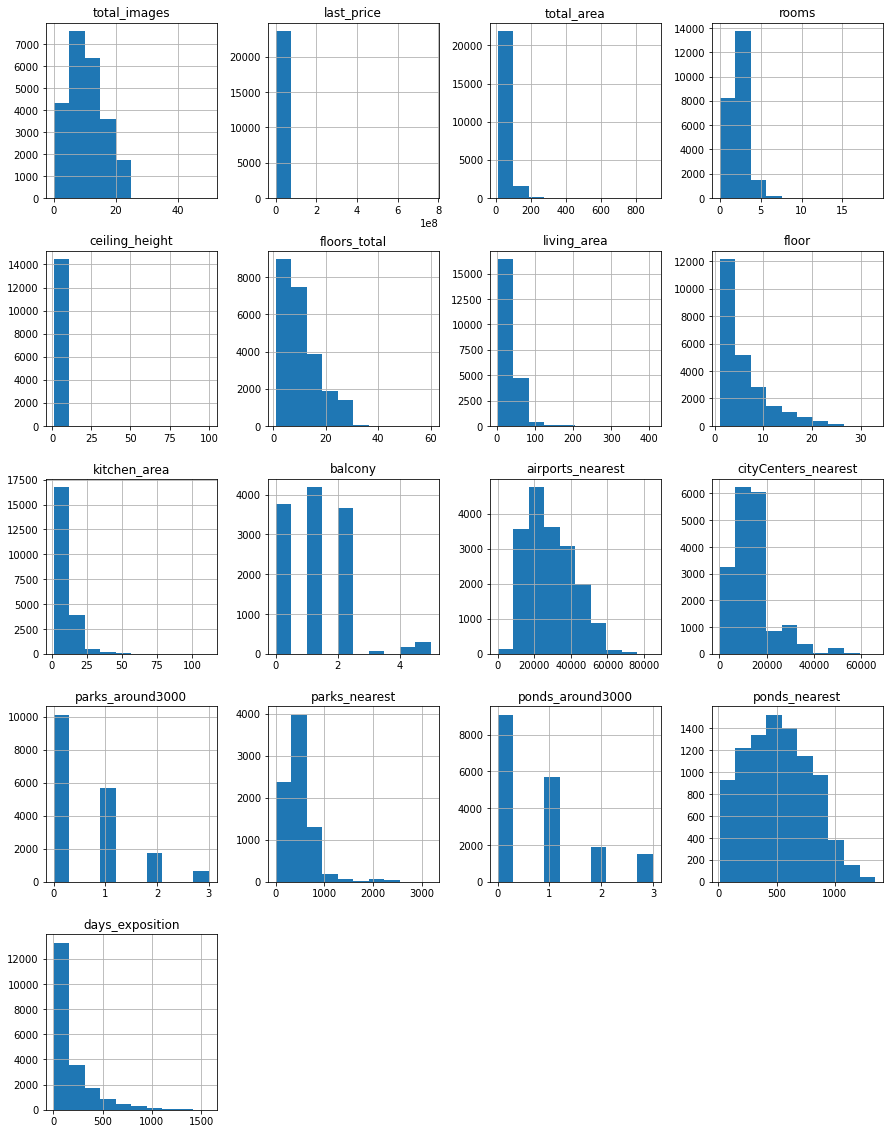

In [4]:
data.hist(figsize=(15, 20));

На гистограмме заметно, что некоторые данные имеют вид нормального рассеяния, а в некоторых содержатся явные перекосы. Это может быть связано с ненормальными пиковыми значениями, шумами и выбросами в данных. Чтобы исправить эту ошибку, необходимо выполнить предобработку и после этого изучить данные повторно. 

### Предобработка данных

#### Удаление пропущенных значений

Первый этап предобработки данных - поиск пропусков и логичная замена или удаление там, где замена невозможна.
Проверим, как много в данных содержится пропусков.

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Наблюдается большое количество пропусков в столбцах с данными о высоте потолков, количестве этажей в доме, жилой площади, типе апартаментов, площади кухни, количества балконов, названии населённого пункта, расстоянии до ближайшего аэропорта, расстоянии до центра города, данных о  ближайших парках и водоёмах, а также о том, как долго было размещено объявление. 
Чтобы исправить эти пропуски, часть данных потребуется удалить, а часть - заполнить медианными значениями. 
Так, данные locality_name о названии населённого пункта нет возможности заменить, и они составляют всего 49 из 23699 строк, поэтому их удаление не исказит репрезентативность и точность данных, и их можно просто удалить. 
Для удобства сравнения в дальнейшем предобработанным данным присваивается название data_filtered.

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

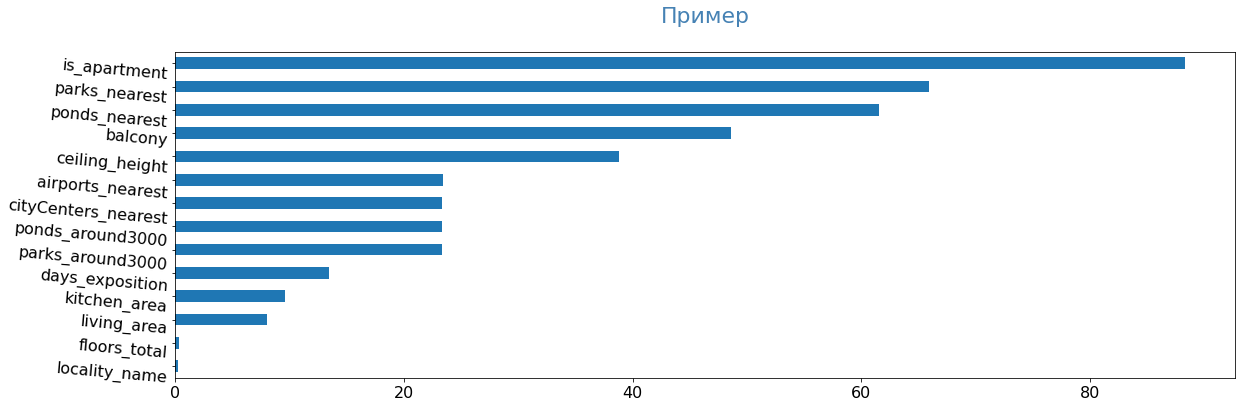

In [7]:
pass_value_barh(data)

In [8]:
data_filtered = data.copy()
data_filtered = data_filtered.dropna(subset=['locality_name'])
data_filtered['locality_name'].isna().sum()

0

Пустые строки из столбца locality_name успешно удалены. 
В случае с пропусками в ceiling_height, высоте потолков, не получится просто отбросить строки с пропусками: они составляют достаточно большую часть от всего датафрейма. К тому же, пропуски в этих данных можно заменить медианным значением для этого столбца. Ввиду отсутвия данных о годе постройки и типе здания(хрущёвка, сталинка и т. д.) сделать более точную категоризацию не представляется возможным. 

In [9]:
data_filtered['ceiling_height'] = data_filtered['ceiling_height'].fillna(value=data_filtered['ceiling_height'].median())
data_filtered['ceiling_height'].isna().sum()

0

Столбец floors_total, хранящий данные о количестве этажей в здании, также не может получить логичную замену и имеет всего 86 пропусков. Поэтому пропуски в этом столбце можно просто удалить, это не повлияет на репрезентативность и точность данных. 

In [10]:
data_filtered = data_filtered.dropna(subset=['floors_total']).copy()
data_filtered['floors_total'].isna().sum()

0

В столбце living_area, хранящим данные о площади жилого помещения, содержится 1903 пропуска, это слишком большое количество строк для того, чтобы можно было их просто отбросить. Также можно заменить пропуски медианным значением площади жилья в зависимости от количества комнат. Так репрезентативность данных будет сохранена.  

In [11]:
for t in data_filtered['rooms'].unique():
    data_filtered.loc[(data_filtered['rooms'] == t) & (data_filtered['living_area'].isna()), 'living_area'] = \
    data_filtered.loc[(data_filtered['rooms'] == t), 'living_area'].median()
    
data_filtered['living_area'].isna().sum()

0

Проверим корректность значений площадей:

In [12]:
check_mistakes = data_filtered.loc[data_filtered['total_area']*0.9 <= (data_filtered['living_area'] + data_filtered['kitchen_area'])]
check_mistakes

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.65,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,NaN,...,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,NaN,...,6.2,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,NaN,...,9.0,NaN,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,NaN,...,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,2.65,5.0,90.2,4,NaN,...,16.0,NaN,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.65,5.0,42.2,2,NaN,...,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.65,14.0,40.0,8,NaN,...,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,2.65,4.0,44.0,2,NaN,...,15.3,NaN,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


В результате заполнения синтетическими данными появилось 504 нелогичных строки, в которых сумма жилой площади и площади кухни больше всей площади. Но 504 строки в данном случае составляют малую часть от всего датафрейма, поэтому их можно удалить: это не слишком сильно исказит данные. 

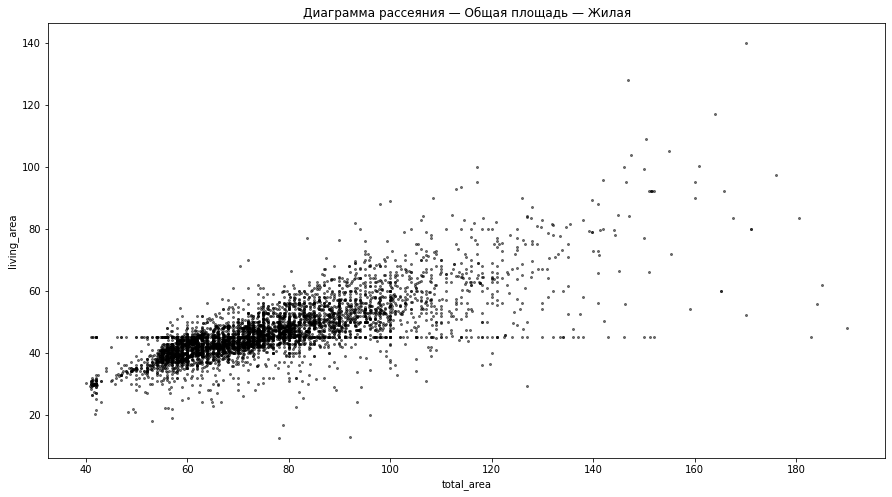

In [13]:
# check
data_filtered[data_filtered['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

#### check nan

In [14]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               12090 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [15]:
data_filtered = data_filtered[(data_filtered['total_area']*0.9 > 
                               (data_filtered['living_area'] + data_filtered['kitchen_area'])) | 
                               (data_filtered['kitchen_area'].isnull()) | (data_filtered['living_area'].isnull())]

In [16]:
# check
data_filtered.shape[0]

23061

В случае с пропусками в столбце balcony логично предположить, что если продавец не указал количество балконов, то их просто нет. Поэтому пропущенные значения в этом столбце можно заполнить 0.

In [17]:
data_filtered['balcony'] = data_filtered['balcony'].fillna(0)
data_filtered['balcony'].isna().sum()

0

Аналогично и с пропусками в is_apartment: если пометку о том, что это апартаменты, не поставили, скорее всего, недвижимость не является апартаментами и на место пропущенных значений можно поставить False.

In [18]:
data_filtered['is_apartment'] = data_filtered['is_apartment'].fillna(False)
data_filtered['is_apartment'].isna().sum()

0

Изучим значения в столбце ponds_around3000, хранящему данные о наличии водоёмов в радиусе 3 км:

In [19]:
data_filtered['ponds_around3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

Логично заменить отсутствующие значения на 0: если бы водоёмы были в этих местах, их бы отметили.

In [20]:
data_filtered['ponds_around3000'] = data_filtered['ponds_around3000'].fillna(0)
data_filtered['ponds_around3000'].isna().sum()

0

Аналогичным образом заполним пропуски в столбце parks_around3000:

In [21]:
data_filtered['parks_around3000'] = data_filtered['parks_around3000'].fillna(0)
data_filtered['parks_around3000'].isna().sum()

0

В случае с пропусками в столбце kitchen_area, хранящим данные о размере кухни, необходимо заполнить значением 0 те строки, где studio=True, поскольку в квартирах-студиях нет выделенной кухни и чаще всего там её площадь указывают как 0. 

In [22]:
for t in data_filtered['studio'].unique():
    data_filtered.loc[(data_filtered['studio'] == True), 'kitchen_area'] = 0
data_filtered['kitchen_area'].isna().sum()

2076

Полностью избавиться от пропусков таким образом не удалось, но количество пропусков уменьшилось. 

In [23]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23061 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23061 non-null  int64  
 1   last_price            23061 non-null  float64
 2   total_area            23061 non-null  float64
 3   first_day_exposition  23061 non-null  object 
 4   rooms                 23061 non-null  int64  
 5   ceiling_height        23061 non-null  float64
 6   floors_total          23061 non-null  float64
 7   living_area           23061 non-null  float64
 8   floor                 23061 non-null  int64  
 9   is_apartment          23061 non-null  bool   
 10  studio                23061 non-null  bool   
 11  open_plan             23061 non-null  bool   
 12  kitchen_area          20985 non-null  float64
 13  balcony               23061 non-null  float64
 14  locality_name         23061 non-null  object 
 15  airports_nearest   

In [24]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23061 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23061 non-null  int64  
 1   last_price            23061 non-null  float64
 2   total_area            23061 non-null  float64
 3   first_day_exposition  23061 non-null  object 
 4   rooms                 23061 non-null  int64  
 5   ceiling_height        23061 non-null  float64
 6   floors_total          23061 non-null  float64
 7   living_area           23061 non-null  float64
 8   floor                 23061 non-null  int64  
 9   is_apartment          23061 non-null  bool   
 10  studio                23061 non-null  bool   
 11  open_plan             23061 non-null  bool   
 12  kitchen_area          20985 non-null  float64
 13  balcony               23061 non-null  float64
 14  locality_name         23061 non-null  object 
 15  airports_nearest   

Проверим, остались ли пропуски в данных:

In [25]:
data_filtered.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2076
balcony                     0
locality_name               0
airports_nearest         5376
cityCenters_nearest      5353
parks_around3000            0
parks_nearest           15215
ponds_around3000            0
ponds_nearest           14214
days_exposition          3086
dtype: int64

Часть пропусков осталась, но они не повлияют на точность данных в результате и для них нельзя предположить логичную замену. 

####  Изучение типов данных в каждом столбце

Рассмотрим типы данных в столбцах.

In [26]:
data_filtered.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Есть столбцы, значения в которых предпочтительнее привести к типу int. Это parks_around3000, ponds_around3000. Они хранят данные о количестве водоёмов и парков в радиусе трёх километров, поэтому могут быть только целочисленными: не может быть двух с половиной парков, может быть только целое число. 


In [27]:
data_filtered['parks_around3000'] = data_filtered['parks_around3000'].astype('int')
data_filtered['ponds_around3000'] = data_filtered['ponds_around3000'].astype('int')

Аналогичным образом следует поступить со столбцами floors_total и balcony: количество этажей и балконов может быть только целым. 

In [28]:
data_filtered['floors_total'] = data_filtered['floors_total'].astype('int')
data_filtered['balcony'] = data_filtered['balcony'].astype('int')

В столбце kitchen_area тип данных object, но предпочтительнее присвоить ему тип float: в столбце хранятся данные о площади кухни, это не обязательно целое число, но обязательно число. 

In [29]:
data_filtered['kitchen_area'] = data_filtered['kitchen_area'].astype('float')

Столбец first_day_exposition хранит в себе дату, поэтому его лучше привести в соответствующий тип данных.

In [30]:
data_filtered['first_day_exposition'] = pd.to_datetime(data_filtered['first_day_exposition'], format='%Y.%m.%d %H:%M:%S')

Столбец last_price также хранит целочисленное значение: логично предполагать, что в ценах на квартиру нет места копейкам. 

In [31]:
data_filtered['last_price'] = data_filtered['last_price'].astype('int')

Также необходимо привести к числовому виду столбцы airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest и days_exposition. Они хранят числовые данные. 

In [32]:
data_filtered['airports_nearest'] = data_filtered['airports_nearest'].astype('float')
data_filtered['cityCenters_nearest'] = data_filtered['cityCenters_nearest'].astype('float')
data_filtered['parks_nearest'] = data_filtered['parks_nearest'].astype('float')
data_filtered['ponds_nearest'] = data_filtered['ponds_nearest'].astype('float')
data_filtered['days_exposition'] = data_filtered['days_exposition'].astype('float')

Проверим, все ли изменения вступили в силу:

In [33]:
data_filtered.dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [34]:
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


#### Удаление неявных дубликатов

Для удаления неявных дубликатов просмотрим уникальные значения в столбце с названиями населённых пунктов. 

In [35]:
data_filtered['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В первую очередь приведём все значения к единому регистру для удобства обработки. 

In [36]:
data_filtered['locality_name'] = data_filtered['locality_name'].str.lower()

Проверим, какой вид теперь имеют значения в столбцах:

In [37]:
data_filtered['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'городской посёлок янино-1',
       'посёлок парголово', 'посёлок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина', 'поселок мурино',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'поселок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', '

Проверим, встречаются ли строки-дубликаты в данных:

In [38]:
data_filtered.duplicated().sum()

0

Для упрощения обработки устраним неявные дубликаты.

In [39]:
word_list = ['поселок', 'деревня', 'посёлок', 'городской', 'коттеджный', 'садоводческое некоммерческое товарищество', 
             'городского типа', 'поселок городского типа', 'посёлок городского типа', 'городской посёлок', 'городской поселок', 
            'садовое товарищество', 'садовое некоммерческое товарищество', 'коттеджный поселок', 'коттеджный посёлок']
name = ''
for d in word_list:
    data_filtered['locality_name'] = data_filtered['locality_name'].replace(d, name, regex=True)
    data_filtered['locality_name'] = data_filtered['locality_name'].str.strip()

Проверим повторно, какие значения остались в столбце. 

In [40]:
data_filtered['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'село путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'село павлово', 'оредеж', 'село копорье', 'молодёжное', 'тихвин',
       'победа', 'нурма', 'синявино', 'тосно', 'стрельна', 

In [41]:
# check
data_filtered.locality_name.nunique()

307

Снова проверим, встречаются ли дубликаты:

In [42]:
data_filtered.duplicated().sum()

0

Проверим, все ли изменения вступили в силу:

In [43]:
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,NaN,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


#### Устранение редких и аномальных значений

В некоторых столбцах могут встречаться редкие, значительно выбивающиеся и искажающие точность данных значения. Просмотрим данные по столбцам, чтобы выявить их.

In [44]:
data_filtered['ceiling_height'].unique()

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76, 25.  ,  2.58,  2.52,  5.2 ,  2.87,  2.66,  2.59,
        2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,
        3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  5.3 ,  5.  ,  2.79,
        2.95,  4.06,  2.94,  3.7 ,  3.82,  3.54,  3.53,  2.83,  4.7 ,
        2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,
        3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,
        3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,
        4.8 ,  4.5 ,  4.2 ,  3.36, 32.  ,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        3.22,  3.27, 27.  ,  4.1 ,  2.68,  2.93,  3.46, 24.  ,  3.47,
        3.33,  3.63,

Построим диаграмму размаха, чтобы определить, какие значения в этом столбце явно выбиваются. 

<AxesSubplot:>

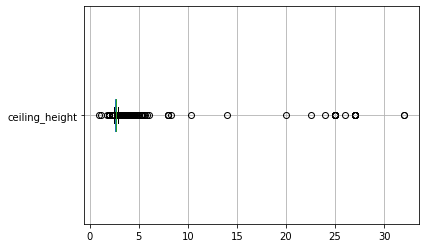

In [45]:
data_filtered.boxplot(column='ceiling_height', vert=False)

В таблице встречаются явно выбивающиеся значения. В случае со значениями от 20 до 40 логично предположить, что на самом деле это вещественные значения в 10 раз меньше, чем указано. В случае со значением 100 предположить логичную замену сложно: потолки в 10 метров встречаются также редко. Поэтому это значение можно отбросить, чтобы избежать искажения в данных. 
Также необходимо устранить значения высота потолков менее 2 метров: они невозможны логчески, СНиП РФ не допускает высоты потолка менее 2,5 метров, и даже если допустить возможность застройки с нарушениями, недвижимость с высотой потолков менее 2 метров непригодна для жизни. 

In [46]:
data_filtered = data_filtered.copy()
data_filtered = data_filtered[(data_filtered['ceiling_height'] < 100)]
data_filtered = data_filtered[(data_filtered['ceiling_height'] > 2)]

Теперь необходимо отобрать все значения высоты больше 20 и разделить их на 10, чтобы получить более верное и адекватное отображение. 

##### check height

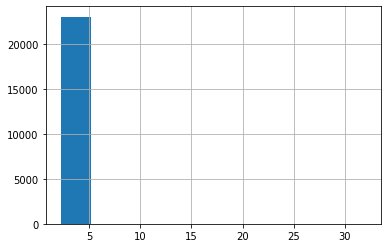

In [47]:
# check
data_filtered['ceiling_height'].hist();

In [48]:
def find_height(height):
    if height > 20:
        return height / 10
    else:
        return height
data['ceiling_height'] = data['ceiling_height'].apply(find_height)

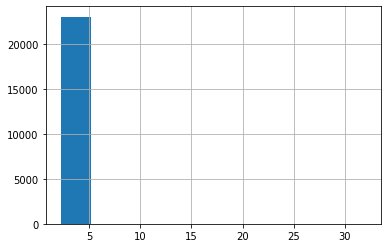

In [49]:
# check
data_filtered['ceiling_height'].hist();

In [50]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23048 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23048 non-null  int64         
 1   last_price            23048 non-null  int64         
 2   total_area            23048 non-null  float64       
 3   first_day_exposition  23048 non-null  datetime64[ns]
 4   rooms                 23048 non-null  int64         
 5   ceiling_height        23048 non-null  float64       
 6   floors_total          23048 non-null  int64         
 7   living_area           23048 non-null  float64       
 8   floor                 23048 non-null  int64         
 9   is_apartment          23048 non-null  bool          
 10  studio                23048 non-null  bool          
 11  open_plan             23048 non-null  bool          
 12  kitchen_area          20974 non-null  float64       
 13  balcony         

Проверим, вступили ли в силу изменения:

In [51]:
data_filtered['ceiling_height'].unique()

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76, 25.  ,  2.58,  2.52,  5.2 ,  2.87,  2.66,  2.59,
        2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,  3.16,
        3.62,  3.12,  2.53,  2.74,  2.96,  5.3 ,  5.  ,  2.79,  2.95,
        4.06,  2.94,  3.7 ,  3.82,  3.54,  3.53,  2.83,  4.7 ,  2.4 ,
        3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,  3.57,
        2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,  3.75,
        2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,  4.8 ,
        4.5 ,  4.2 ,  3.36, 32.  ,  3.08,  3.68,  3.07,  3.37,  3.09,
        8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,  3.22,
        3.27, 27.  ,  4.1 ,  2.68,  2.93,  3.46, 24.  ,  3.47,  3.33,
        3.63,  3.32,

Теперь все значения в столбце ceiling_height находятся в пределах нормы. 

Необходимо также проверить и значения в других числовых столбцах.

In [52]:
data_filtered['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

<AxesSubplot:>

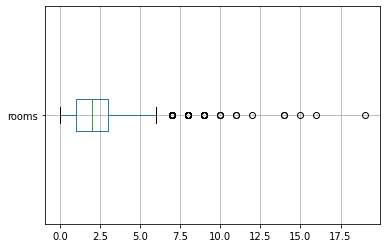

In [53]:
data_filtered.boxplot(column='rooms', vert=False)

На диаграмме размаха видно, что ряд значений сильно выбивается и искажает данные. 
Подсчитаем, как много явно выбивающихся значений:

In [54]:
data_filtered.groupby(by='rooms')['rooms'].count()

rooms
0      194
1     7861
2     7739
3     5621
4     1132
5      314
6       97
7       59
8       12
9        8
10       3
11       2
12       1
14       2
15       1
16       1
19       1
Name: rooms, dtype: int64

Значения больше 8 единичны и значительно выбиваются. Их удаление не исказит данные в целом, но позволит добиться большей репрезентативности. 

In [55]:
data_filtered = data_filtered.copy()
data_filtered = data_filtered[(data_filtered['rooms'] < 7)]

Проверим, как теперь выглядит диаграмма размаха:

<AxesSubplot:>

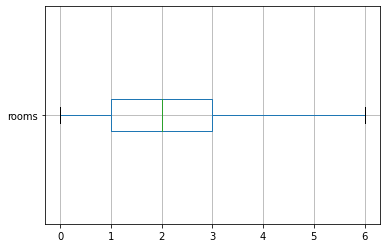

In [56]:
data_filtered.boxplot(column='rooms', vert=False)

Также проверим показатели в столбцах floors_total, living_area, floor, balcony.

In [57]:
data_filtered['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52])

В столбце floors_total встречаются большие значения, но они вполне объяснимы: есть здания, в которых очень много этажей. Тем не менее, для большей точности статистики лучше устранить значительно выбивающиеся значения: зданий высотой больше, чем в 30 этажей, немного, но они могут исказить точность вычислений.

<AxesSubplot:>

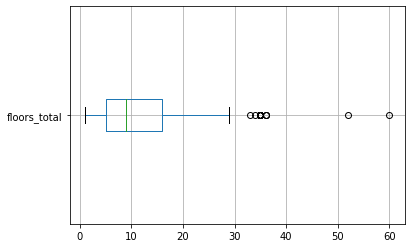

In [58]:
data_filtered.boxplot(column='floors_total', vert=False)

Удалим строки, хранящие в столбце floors_total значения больше 30. 

In [59]:
data_filtered = data_filtered[(data_filtered['floors_total'] < 30)]

Теперь диаграмма размаха выглядит нормально. 

<AxesSubplot:>

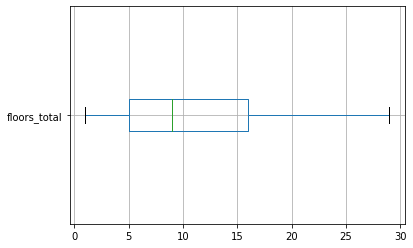

In [60]:
data_filtered.boxplot(column='floors_total', vert=False)

<AxesSubplot:>

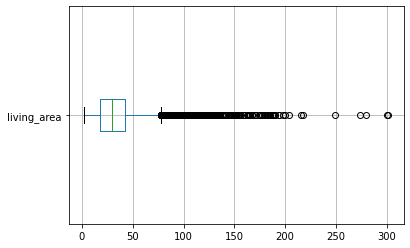

In [61]:
data_filtered.boxplot(column='living_area', vert=False)

На диаграмме размаха, показывающей жилую площадь, видно, что многие значения выбиваются очень сильно, и при этом их немного. Значения больше 120 единичны, но искажают диаграмму, поэтому их можно отбросить. 

In [62]:
data_filtered = data_filtered[(data_filtered['living_area'] < 120)]

In [63]:
# check
data_filtered.shape[0]

22789

<AxesSubplot:>

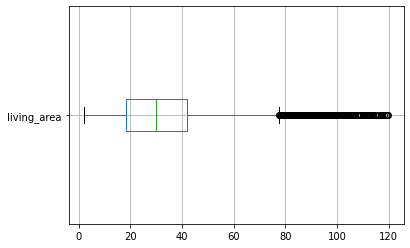

In [64]:
data_filtered.boxplot(column='living_area', vert=False)

Также необходимо изучить столбец, хранящий данные об общей площади недвижимости. 

<AxesSubplot:>

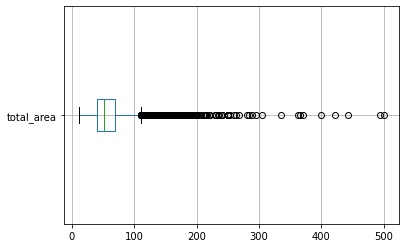

In [65]:
data_filtered.boxplot(column='total_area', vert=False)

На диаграмме размаха видно, что значительно выбивающихся аномальных значений достаточно много. Часть из них всё же можно отбросить: это значения больше 300. 
Другие выделяющиеся значения удалять не стоит: их слишком много для того, чтобы можно было удалить их, не утратив важные данные. К тому же, недвижимость с большой площадью до 200 квадратных метров действительно существует.

In [66]:
data_filtered = data_filtered[(data_filtered['total_area'] < 200)]

<AxesSubplot:>

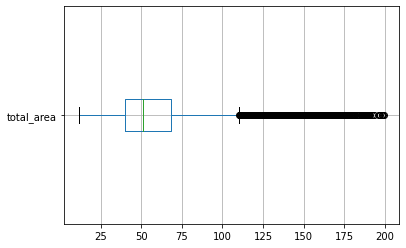

In [67]:
data_filtered.boxplot(column='total_area', vert=False)

Необходимо проверить также столбец с данными о площади кухни. 

<AxesSubplot:>

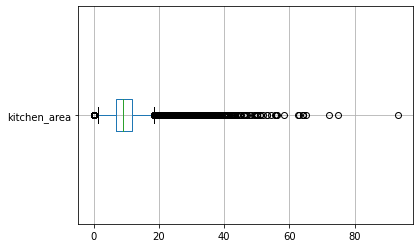

In [68]:
data_filtered.boxplot(column='kitchen_area', vert=False)

В случае с этим столбцом необходимо сначала исключить аномальные значения, не соответствующие реальности. Отбросим строки, в которых площадь кухни больше жилой площади или общей площади: это физически невозможно, поэтому они только исказят данные. 

#### check nan

In [69]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22736 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22736 non-null  int64         
 1   last_price            22736 non-null  int64         
 2   total_area            22736 non-null  float64       
 3   first_day_exposition  22736 non-null  datetime64[ns]
 4   rooms                 22736 non-null  int64         
 5   ceiling_height        22736 non-null  float64       
 6   floors_total          22736 non-null  int64         
 7   living_area           22736 non-null  float64       
 8   floor                 22736 non-null  int64         
 9   is_apartment          22736 non-null  bool          
 10  studio                22736 non-null  bool          
 11  open_plan             22736 non-null  bool          
 12  kitchen_area          20701 non-null  float64       
 13  balcony         

In [70]:
data_filtered = data_filtered[(data_filtered['kitchen_area'] < data_filtered['total_area']) | (data_filtered['kitchen_area'].isnull())]
data_filtered = data_filtered[(data_filtered['kitchen_area'] < data_filtered['living_area'])| (data_filtered['kitchen_area'].isnull()) | (data_filtered['living_area'].isnull())]

In [71]:
# check
data_filtered.shape[0]

22355

Рассмотрим полученный столбец повторно.

<AxesSubplot:>

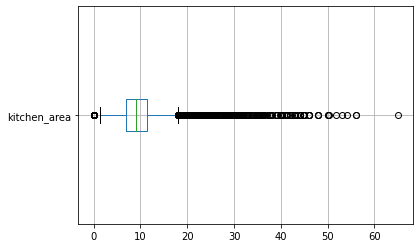

In [72]:
data_filtered.boxplot(column='kitchen_area', vert=False)

Выбивающиеся значения остались, но их стало меньше, и теперь видно, что можно удалить строки с площадью кухни больше 35: их немного. 

In [73]:
data_filtered = data_filtered[(data_filtered['kitchen_area'] < 35)]

In [74]:
# check
data_filtered.shape[0]

20232

<AxesSubplot:>

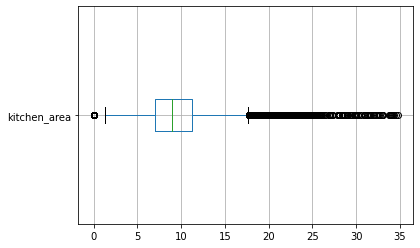

In [75]:
data_filtered.boxplot(column='kitchen_area', vert=False)

<AxesSubplot:>

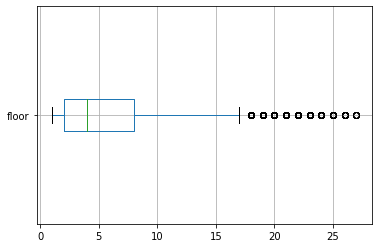

In [76]:
data_filtered.boxplot(column='floor', vert=False)

На диаграмме размаха видно, что многие данные выбиваются. В первую очередь необходимо убрать искажения логически: этаж здания не может быть больше, чем общее количество этажей в здании. Следовательно, будет логично исключить такие строки. 

In [77]:
data_filtered = data_filtered[(data_filtered['floor'] <= data_filtered['floors_total'])]

<AxesSubplot:>

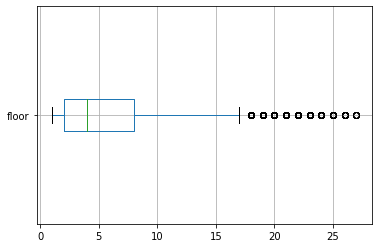

In [78]:
data_filtered.boxplot(column='floor', vert=False)

Количество выбивающихся данных уменьшилось, и теперь они логичны. 

<AxesSubplot:>

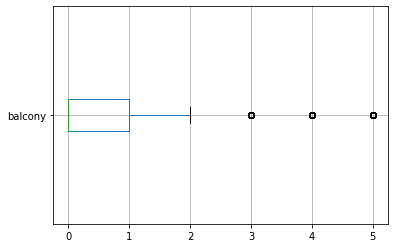

In [79]:
data_filtered.boxplot(column='balcony', vert=False)

Во всех столбцах встречаются большие значения, но логически понятно, что при общем преобладании малоэтажных зданий и 1-2 балконов также встречаются и многоэтажные здания, и квартиры с большим количеством балконов. 

<AxesSubplot:>

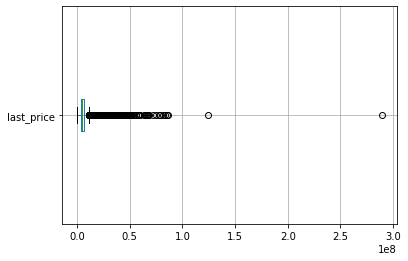

In [80]:
data_filtered.boxplot(column='last_price', vert=False)

В этом столбце встречаются единичные аномальные значения. Удалим строки со значениями более 20 000 000. 

In [81]:
# check
data_filtered.shape[0]

20232

In [82]:
data_filtered = data_filtered[(data_filtered['last_price'] < 20000000)]

In [83]:
# check
data_filtered.shape[0]

19878

<AxesSubplot:>

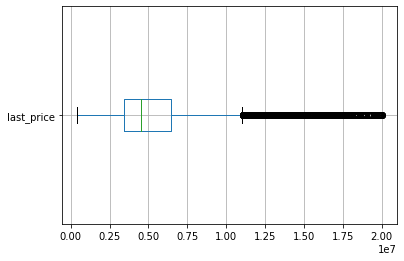

In [84]:
data_filtered.boxplot(column='last_price', vert=False)

Проверим, какой вид теперь имеет таблица:

In [85]:
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,9.1,0,янино-1,NaN,NaN,0,NaN,0,NaN,55.0
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,18.9,2,санкт-петербург,23982.0,11634.0,0,NaN,0,NaN,NaN


#### Промежуточный вывод

В ходе предобработки были заполнены пропуски там, где возможно предположить логичную замену, и удалены нелогичные пиковые значения, искажающие точность статистики. 

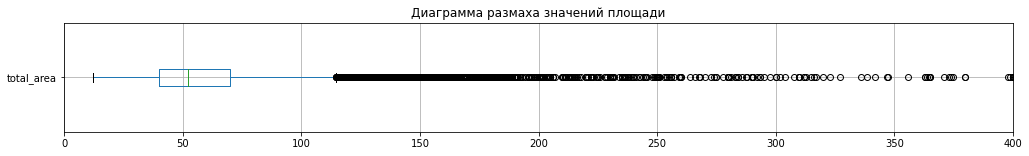

In [86]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

#### check gap

In [87]:
# check
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19878 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19878 non-null  int64         
 1   last_price            19878 non-null  int64         
 2   total_area            19878 non-null  float64       
 3   first_day_exposition  19878 non-null  datetime64[ns]
 4   rooms                 19878 non-null  int64         
 5   ceiling_height        19878 non-null  float64       
 6   floors_total          19878 non-null  int64         
 7   living_area           19878 non-null  float64       
 8   floor                 19878 non-null  int64         
 9   is_apartment          19878 non-null  bool          
 10  studio                19878 non-null  bool          
 11  open_plan             19878 non-null  bool          
 12  kitchen_area          19878 non-null  float64       
 13  balcony         

In [88]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data_filtered[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"19,878.00","19,878.00","19,878.00","17,236.00","19,878.00","19,878.00","19,878.00","19,878.00","19,878.00"
min,0.00,15.50,2.25,1.00,"430,000.00",2.00,0.00,1.00,1.00
max,6.00,197.00,32.00,"1,580.00","19,999,000.00",119.90,34.78,27.00,28.00
median,2.00,51.00,2.65,99.00,"4,550,000.00",30.00,9.00,4.00,9.00


В таблице заметно, что ещё в нескольких столбцах остались аномалии: это данные об общей площади, днях публикации объявления, конечной цене, жилой площади, площади кухни и общем количестве этажей. Для дальнейшего анализа необходимо устранить их.

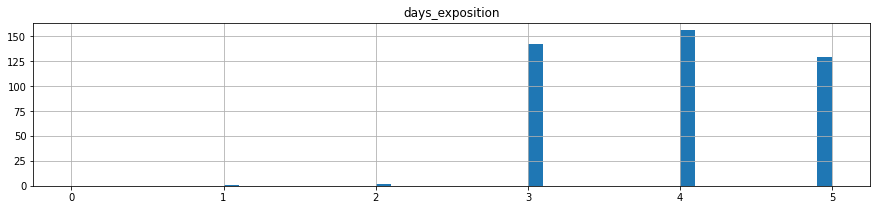

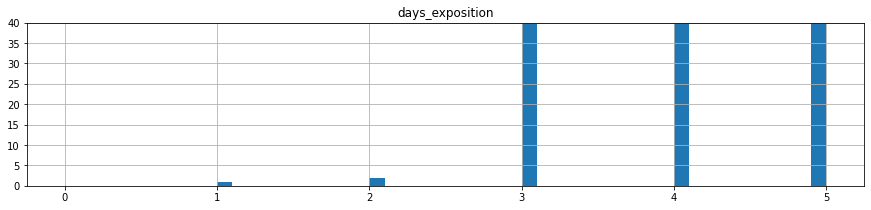

In [89]:
# check
data_filtered.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data_filtered.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

В таблице видно, что встречаются аномальные значения в столбце ceiling_height: 32 метра как максимальное значение; 'days_exposition' - 1-2 дня и 1580 дней в скорости продаж.

Для точности данных допустимо отбросить данные о высоте потолков более 5 метров.

In [90]:
# check
data_filtered.shape[0]

19878

In [91]:
data_filtered = data_filtered[(data_filtered['ceiling_height'] < 5)]

In [92]:
# check
data_filtered.shape[0]

19858

<AxesSubplot:>

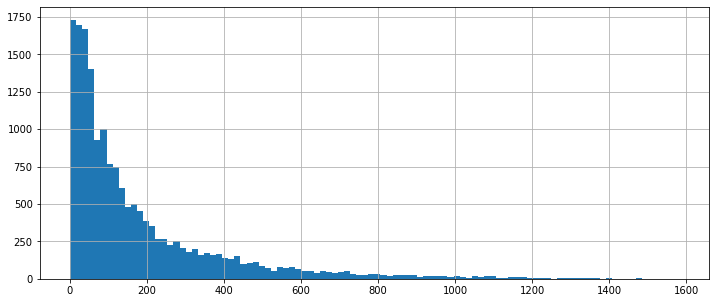

In [93]:
data_filtered['days_exposition'].hist(bins=100, figsize=(12,5))

Также необходимо удалить данные о скорости продаж меньше 5 дней и больше 1200: эти данные искажают точность статистики. 

In [94]:
data_filtered = data_filtered[(data_filtered['days_exposition'] > 5)| (data_filtered['days_exposition'].isnull()) | (data_filtered['days_exposition'].isnull())]
data_filtered = data_filtered[(data_filtered['days_exposition'] < 1200)| (data_filtered['days_exposition'].isnull()) | (data_filtered['days_exposition'].isnull())]


In [95]:
# check
data_filtered.shape[0]

19355

Также необходимо очистить от аномалий столбец kitchen_area.

<AxesSubplot:>

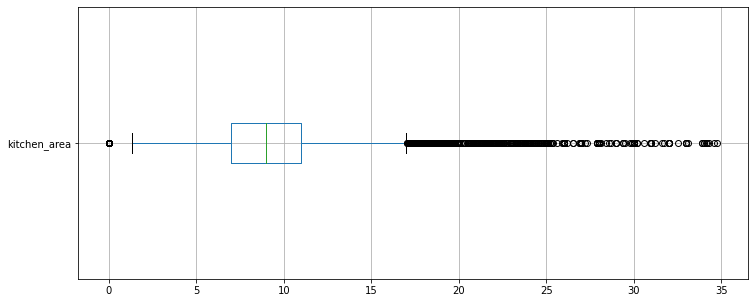

In [96]:
data_filtered.boxplot(column='kitchen_area', vert=False, figsize=(12,5))

In [97]:
data_filtered = data_filtered[(data_filtered['kitchen_area'] > 3)| (data_filtered['kitchen_area'].isnull()) | (data_filtered['kitchen_area'].isnull())]
data_filtered = data_filtered[(data_filtered['kitchen_area'] < 30)| (data_filtered['kitchen_area'].isnull()) | (data_filtered['kitchen_area'].isnull())]


In [98]:
# check
data_filtered.shape[0]

19156

In [99]:
 (
    data_filtered[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)      

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"19,156.00","19,156.00","19,156.00","16,544.00","19,156.00","19,156.00","19,156.00","19,156.00","19,156.00"
min,1.00,21.00,2.25,6.00,"430,000.00",8.30,3.20,1.00,1.00
max,6.00,197.00,4.80,"1,199.00","19,999,000.00",119.90,29.90,27.00,28.00
median,2.00,51.30,2.65,103.00,"4,590,000.00",30.00,9.00,4.00,9.00


In [100]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [101]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


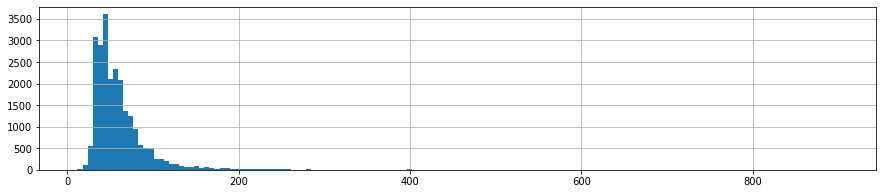

In [102]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

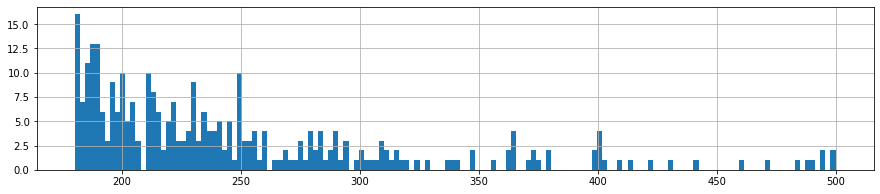

In [103]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

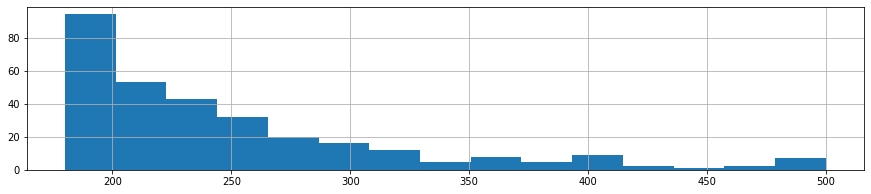

In [104]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

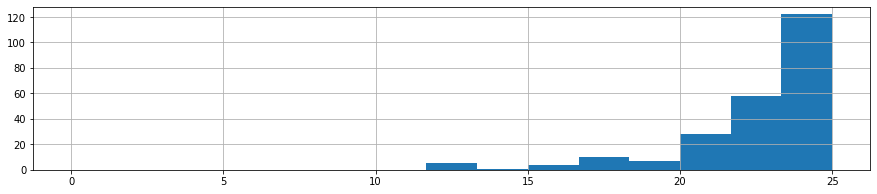

In [105]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [106]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.00,2.30,3.00,"562,188.00",10.00,3.77,1.00,2.00
0.01,1.00,25.20,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.99,5.00,197.21,3.80,"1,068.66","36,000,000.00",120.00,35.09,23.00,26.00
0.9988,8.00,380.00,4.76,"1,369.90","124,772,448.00",219.69,60.00,26.00,35.00


In [107]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data_filtered[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,1.00,25.00,2.45,6.00,"600,000.00",12.00,4.00,1.00,2.00
0.01,1.00,29.12,2.50,7.00,"1,050,000.00",14.00,5.00,1.00,2.00
0.5,2.00,51.30,2.65,103.00,"4,590,000.00",30.00,9.00,4.00,9.00
0.99,5.00,133.18,3.50,982.57,"16,500,000.00",83.00,22.50,22.00,26.00
0.9988,6.00,170.00,4.00,"1,161.30","19,370,420.00",110.30,28.00,26.00,27.00


### Посчитайте и добавьте в таблицу новые столбцы

Таблица станет значительно информативнее, если дополнить данные. 
Добавим в таблицу цену квадратного метра, день недели, месяц и год публикации объявления, тип этажа квартиры и расстояние до центра города в километрах. 

Чтобы рассчитать цену квадратного метра, необходимо разделить цену продажи last_price на площадь недвижимости total_area. 

In [108]:
data_filtered['price_for_meter'] = data_filtered['last_price'] / data_filtered ['total_area']
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.789474
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,2,санкт-петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.692737


Последовательно добавим также день недели, месяц и год публикации объявления:

In [109]:
data_filtered['weekday_post'] = pd.DatetimeIndex(data_filtered['first_day_exposition']).weekday
data_filtered['month_post'] = pd.DatetimeIndex(data_filtered['first_day_exposition']).month
data_filtered['year_post'] = pd.DatetimeIndex(data_filtered['first_day_exposition']).year
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_post,month_post,year_post
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,NaN,120370.370370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603.0,0,NaN,0,NaN,81.0,82920.792079,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558.0,92785.714286,3,8,2015
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,0,NaN,0,NaN,55.0,95065.789474,0,9,2018
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,11634.0,0,NaN,0,NaN,NaN,110544.692737,3,4,2019


Следующий этап - добавление типа этажа квартиры. Многим покупателям важно, чтобы этаж не был первым или последним.

In [110]:
def categorize_floors(row):
    try:
        floor = row['floor']
        floors_total = row['floors_total']
        
        if floor == 1: 
            return 'первый'
        if floor == floors_total:
            return 'последний'
        elif 1 < floor < floors_total:
            return 'другой'
        return 'подвал'
    except:
        return 'без категории'

In [111]:
data_filtered['category_floor'] = data_filtered.apply(categorize_floors, axis = 1)
data_filtered.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_post,month_post,year_post,category_floor
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,1,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,0,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,1,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,0,NaN,0,NaN,55.0,95065.789474,0,9,2018,другой
7,5,7915000,71.60,2019-04-18,2,2.65,24,30.50,22,False,...,0,NaN,0,NaN,NaN,110544.692737,3,4,2019,другой
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,...,0,NaN,0,NaN,189.0,87454.764777,2,5,2018,другой
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,0,NaN,0,NaN,289.0,88524.590164,6,2,2017,другой
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.30,3,False,...,1,310.0,2,553.0,137.0,127525.252525,3,11,2017,другой
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.00,4,False,...,0,NaN,0,NaN,7.0,75000.000000,0,8,2018,другой
12,10,3890000,54.00,2016-06-30,2,2.65,5,30.00,5,False,...,0,NaN,0,NaN,90.0,72037.037037,3,6,2016,последний


Также необходимо рассчитать расстояние до центра города в километрах и округлить до целых значений.

In [112]:
data_filtered['cityCenters_nearest_km'] = data_filtered['cityCenters_nearest'] / 1000
data_filtered['cityCenters_nearest_km'] = round(data_filtered['cityCenters_nearest_km'])
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_post,month_post,year_post,category_floor,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,0,NaN,55.0,95065.789474,0,9,2018,другой,NaN
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,NaN,0,NaN,NaN,110544.692737,3,4,2019,другой,12.0


### Проведите исследовательский анализ данных

Для начала построим гистограммы для всех стобцов обработанного датафрейма, чтобы посмотреть, как изменились данные и какие выводы можно сделать из них теперь. 

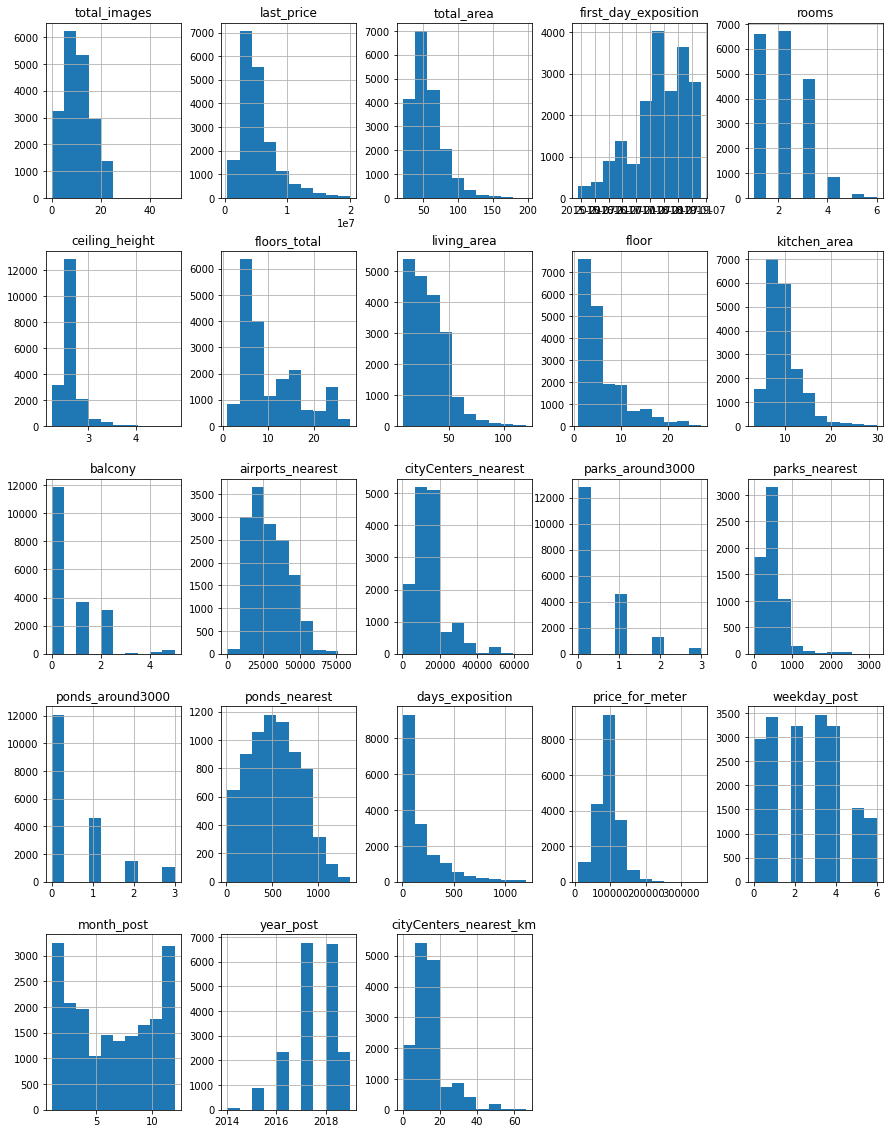

In [113]:
data_filtered.hist(figsize=(15, 20));

Большая часть гистограмм показывает нормальное рассеивание, что подтверждает правильность предобработки данных. Изучим их подробнее. 

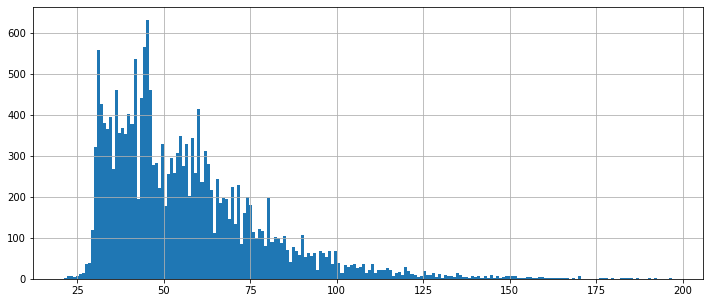

In [114]:
data_filtered['total_area'].hist(bins=200, figsize = (12, 5));

На диаграмме значений общей площади квартир видно, что преимущественно квартиры имеют площадь до 100 квадратных метров. Квартир площадью более 200 квадратных метров достаточно мало.

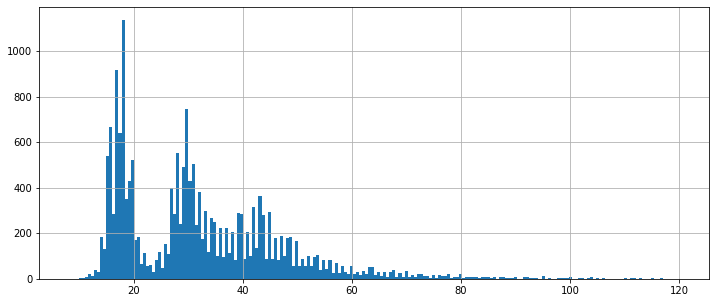

In [115]:
data_filtered['living_area'].hist(bins=200, figsize = (12, 5));

Жилая площадь в квартирах логично ещё меньше: в большинстве квартир менее 50 квадратных метров.

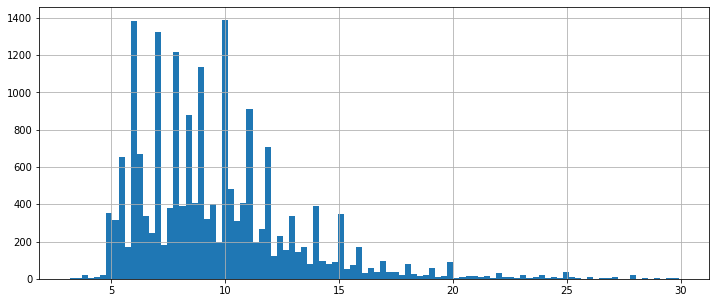

In [116]:
data_filtered['kitchen_area'].hist(bins=100, figsize = (12, 5));

Площадь кухни чаще всего невелика: до 20 квадратных метров. Наблюдается небольшой пик у отметки 0: это объясняется тем, что в квартирах-студиях выделенная кухня как таковая отсутствует.

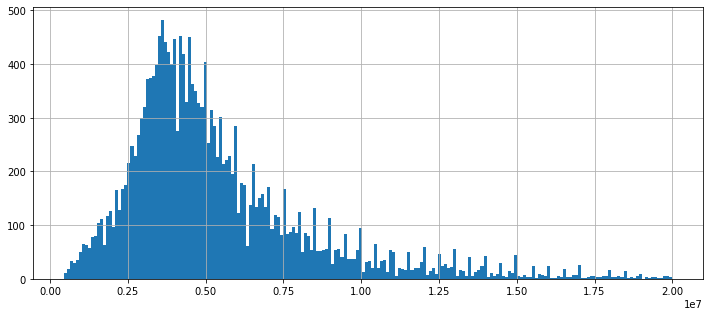

In [117]:
data_filtered['last_price'].hist(bins=200, figsize = (12, 5));

Цена недвижимости достаточно высока.

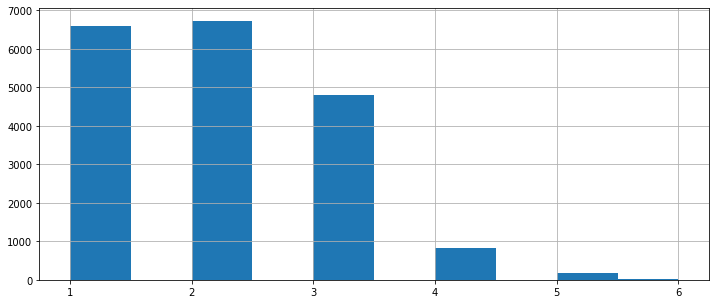

In [118]:
data_filtered['rooms'].hist(bins=10, figsize = (12, 5));

Больше всего однокомнатных квартир. Почти столько же двухкомнатных. В целом распределение комнат логично.

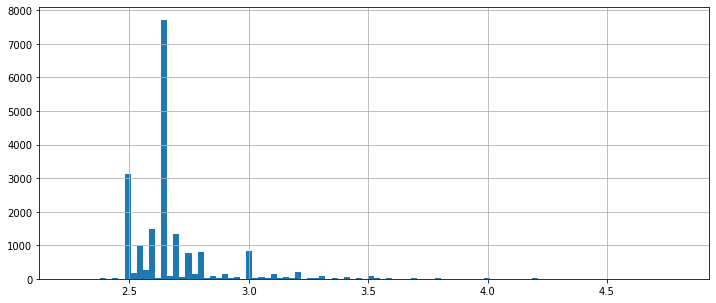

In [119]:
data_filtered['ceiling_height'].hist(bins=100, figsize = (12, 5));

Высота потолков в среднем от 2,5 до 3 метров. Самая распространённая высота - около 2,8.

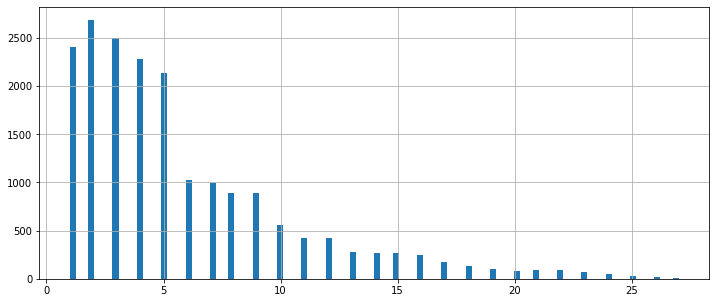

In [120]:
data_filtered['floor'].hist(bins=100, figsize = (12, 5));

Большинство квартир расположены на этажах с первого по пятый: это логично, много вторичного жилья находится в пятиэтажных зданиях старой постройки. Вторая обширная группа - с 5 по 9. Квартир, расположенных выше 9 этажа, немного.

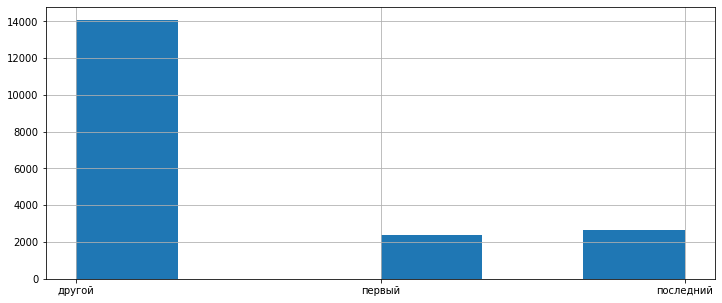

In [121]:
data_filtered['category_floor'].hist(bins=6, figsize = (12, 5));

Большинство квартир располагаются не на первом или последнем этаже. Квартир на последнем этаже больше, чем на первом.

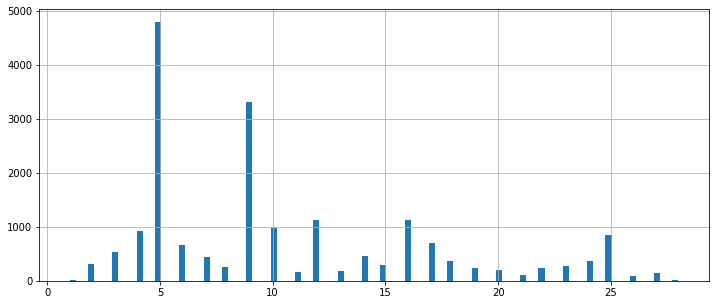

In [122]:
data_filtered['floors_total'].hist(bins=100, figsize = (12, 5));

В большинстве случаев количество этажей в доме - 5 или 9, это видно по большим пикам в вычислениях. Это логично: такой формат застройки на данный момент один из самых распространённых во всех городах. 

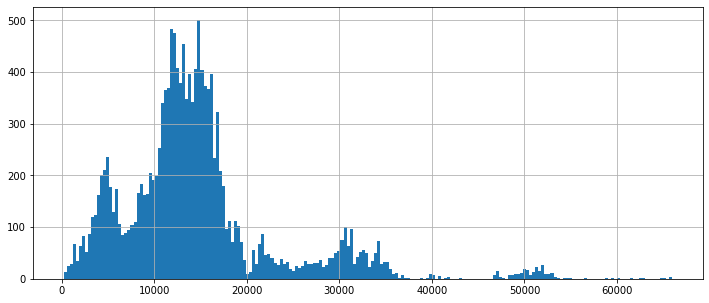

In [123]:
data_filtered['cityCenters_nearest'].hist(bins=200, figsize = (12, 5));

Многие квартиры находятся близко к центру города. Чаще всего - в пределах 20 километров. 

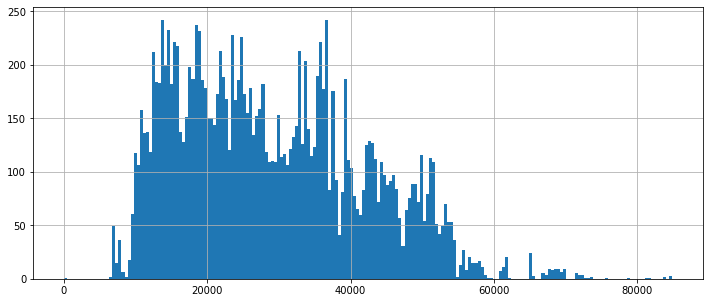

In [124]:
data_filtered['airports_nearest'].hist(bins=200, figsize = (12, 5));

Большинство квартир находятся на расстоянии не более 40 километров от аэропорта. 

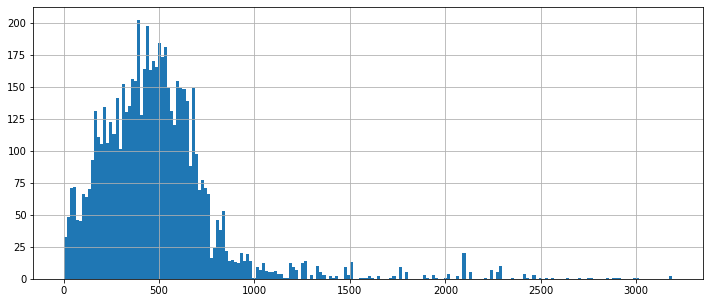

In [125]:
data_filtered['parks_nearest'].hist(bins=200, figsize = (12, 5));

Очень много квартир, расположеннных в пределах километра к паркам: такое жильё можно считать удачным.

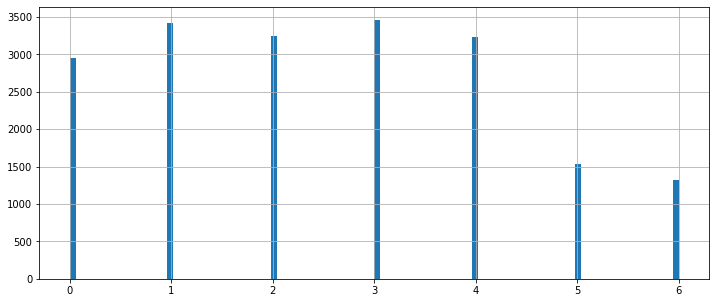

In [126]:
data_filtered['weekday_post'].hist(bins=100, figsize = (12, 5));

На графике видно, что чаще всего объявления публикуют по вторникам и четвергам. Но другие будние дни тоже имеют высокие показатели. Закономерна просадка почти втрое по выходным: по субботам и воскресеньям риелторы чаще всего отдыхают.

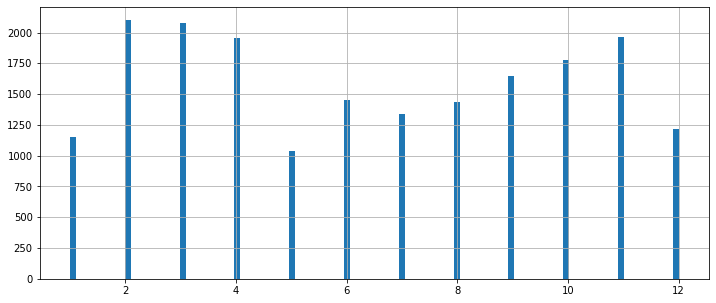

In [127]:
data_filtered['month_post'].hist(bins=100, figsize = (12, 5));

Большинство объявлений публикуют весной и осенью. Закономерно в декабре и январе люди меньше стремятся продавать недвижимость: праздничный период и завершение отчётного периода не оставляют слишком много времени для этого. Также и в период с мая по август: чаще всего это период отпусков. 

#### Промежуточный вывод

Большая часть квартир имеет площадь до 100 квадратных метров, жилую площадь менее 50 и площадь кухни менее 20 квадратных метров. В гистограмме площади кухни наблюдается пик около 0: это обсуловлено тем, что в квартирах-студиях отсутствует выделенная кухня, поэтому её площадь указывают как 0. В большинстве квартир 1 или 2 комнаты. Большая часть квартир находится с 1 по 5 этаж, также обширна группа квартир с 5 по 9. Квартир, расположенных выше, чем на 9 этаже, немного. Чаще всего квартиры расположены не на первом или последнем этажах.  
Большая часть квартир находятся в пределах 20 километров от центра города, 40 километров от аэропорта и километра от парков. 
Чаще всего объявления публикуют в будние дни, весной и осенью. 

### Изучение общей скорости продажи квартиры

Изучим среднюю скорость продажи квартиры:

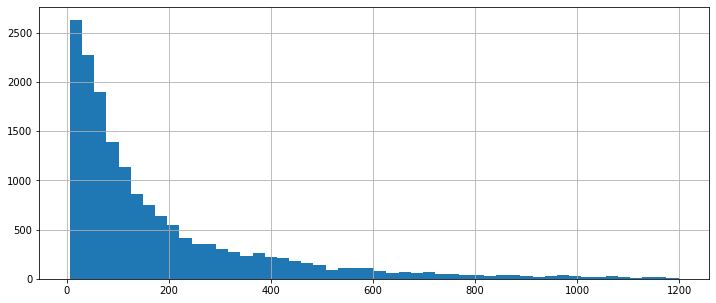

In [128]:
data_filtered['days_exposition'].hist(bins=50, figsize = (12, 5));

Большинство квартир продаётся в течение 200 дней.
Изучим также средние и медианные значения для этого столбца.

In [129]:
data_filtered['days_exposition'].mean()

181.9730415860735

In [130]:
data_filtered['days_exposition'].median()

103.0

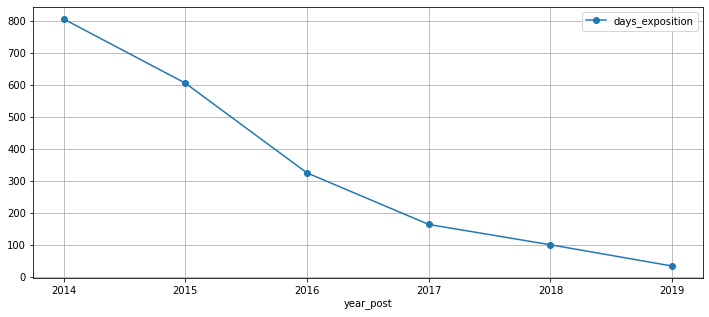

In [131]:
data_filtered.pivot_table(index='year_post', values='days_exposition', aggfunc='mean').plot(label='Средняя скорость продажи по годам', grid=True, style ='o-', figsize=(12, 5));

На графике видно, что с 2014 года продажи в среднем стали происходить во много раз быстрее. 

#### Промежуточный вывод

Среднее арифметическое и медианные значения различаются почти в два раза. 
Необычно быстрыми можно считать продажи за 40 и менее дней, а необычно длинными - продажи дольше 200 дней.

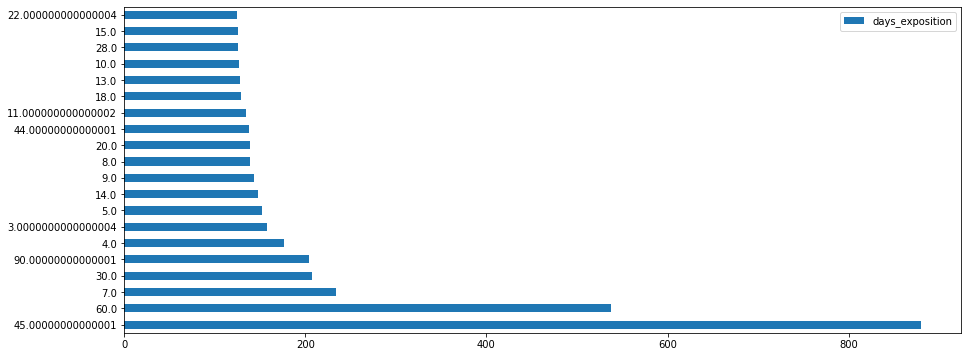

In [132]:
# check
# Моды на реальных данных

    
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

#### Изучение факторов, сильнее всего влияющих на стоимость объекта

Необходимо также изучить, какие факторы сильнее всего влияют на стоимость объекта. Необходимо определить, зависит ли цена от общей площади, жилой площади, площади кухни, количества комнат, типа этажа, на котором расположена квартира и даты размещения. 
Также, чтобы упростить вычисления и построение графиков, добавим столбец, хранящий цену на недвижимость в миллионах - так диаграммы будут нагляднее, а вычисления проще.  

In [133]:
data_filtered['last_price_mil'] = data_filtered['last_price'] / 1000000
data_filtered.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_post,month_post,year_post,category_floor,cityCenters_nearest_km,last_price_mil
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0,13.000
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0,3.350
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0,5.196
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,NaN,55.0,95065.789474,0,9,2018,другой,NaN,2.890
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,0,NaN,NaN,110544.692737,3,4,2019,другой,12.0,7.915


Рассчитаем коэффициент корреляции Пирсона, чтобы понять, есть ли связь между ценой недвижимости и общей площадью.

In [134]:
data_filtered['last_price_mil'].corr(data_filtered['total_area'])

0.7671866938542683

Судя по коэффициенту корреляции Пирсона, связь между этими двумя параметрами есть. Построим диаграмму рассеяния, чтобы получить наглядный результат

<AxesSubplot:xlabel='last_price_mil', ylabel='total_area'>

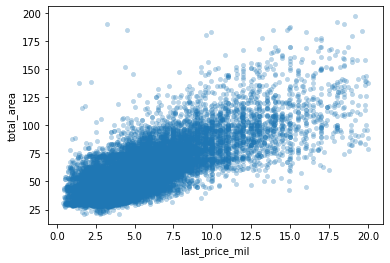

In [135]:
data_filtered.plot(x='last_price_mil', y='total_area', kind='scatter', linewidth= 0.3, alpha = 0.3)

На диаграмме видно, что чем больше площадь квартиры, тем больше и цена. 

Рассчитаем коэффициент корреляции Пирсона снова для выявления связи между жилой площадью и ценой. 

In [136]:
data_filtered['last_price_mil'].corr(data_filtered['living_area'])

0.662371401873674

Зависимость также есть, хотя и несколько меньше, чем между общей площадью и ценой. Построим диаграмму для наглядности:

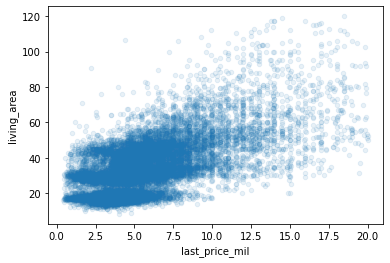

In [137]:
data_filtered.plot(x='last_price_mil', y='living_area', kind='scatter', alpha=0.1);

Здесь также видна зависимость: чем больше жилая площадь, тем больше цена.
Теперь необходимо рассчитать коэффициент корреляции для цены и площади кухни.

In [138]:
data_filtered['last_price_mil'].corr(data_filtered['kitchen_area'])

0.5850112548296829

Взаимосвязь есть. Построим диаграмму, чтобы изучить её. 

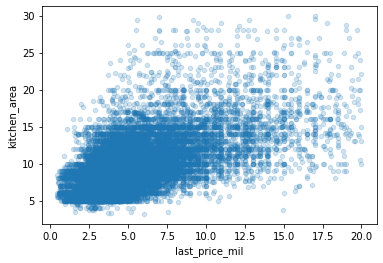

In [139]:
data_filtered.plot(x='last_price_mil', y='kitchen_area', kind='scatter', alpha=0.2);

Наблюдается тенденция к повышению цены с увеличением площади недвижимости. 
Теперь необходимо изучить взаимосвязь между количеством комнат и ценой. 

In [140]:
data_filtered['last_price_mil'].corr(data_filtered['rooms'])

0.4993722624292936

Здесь зависимость невелика. Изучим данные на диаграмме:

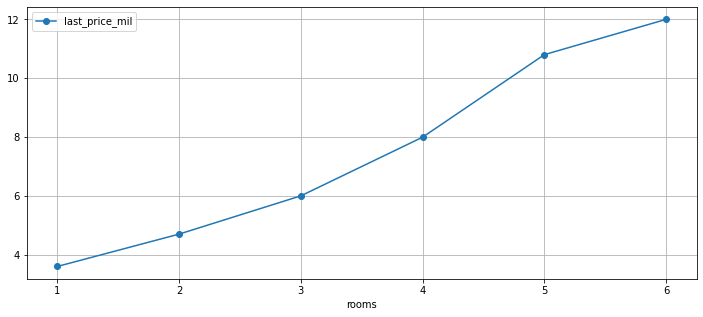

In [141]:
#data_filtered.plot(x='rooms', y='last_price_mil', kind='scatter', alpha=0.2)
data_filtered.pivot_table(index='rooms', values='last_price_mil', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

В целом можно сказать, что чем больше комнат, тем дороже недвижимость. Но этот параметр оказывает не такое большое влияние на общую цену недвижимости. 

Теперь необходимо изучить взаимосвязь между типом этажа и ценой. 

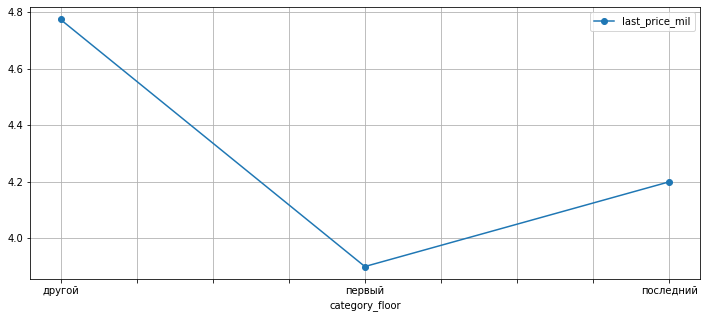

In [142]:
#data_filtered.plot(x='category_floor', y='last_price_mil', kind='scatter')
data_filtered.pivot_table(index='category_floor', values='last_price_mil', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

Из диаграммы можно сделать вывод, что наибольшую стоимость имеют квартиры не на первом этаже. Квартиры на первом и последнем этажах имеют в среднем более высокую цену, чем квартиры на первом.

Наблюдается тенденция к повышению цены с увеличением площади недвижимости. 
Теперь необходимо изучить взаимосвязь между датой размещения и ценой. 

In [143]:
data_filtered['last_price_mil'].corr(data_filtered['weekday_post'])

-0.0122780052633975

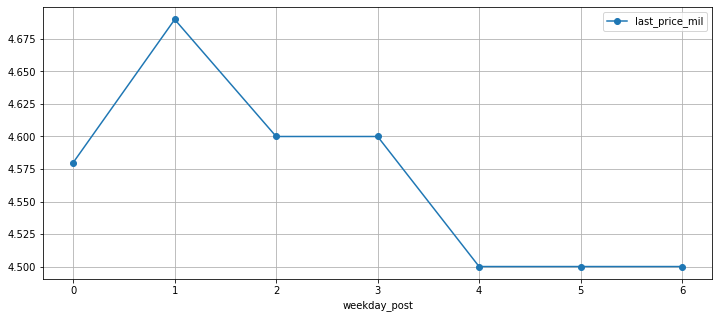

In [144]:
data_filtered.pivot_table(index='weekday_post', values='last_price_mil', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

In [145]:
data_filtered['last_price_mil'].corr(data_filtered['month_post'])

0.007495905295866475

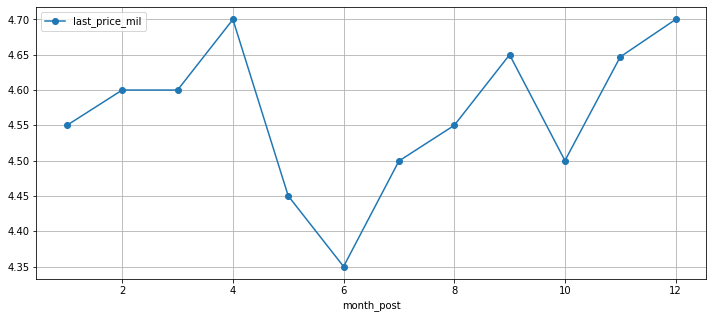

In [146]:
data_filtered.pivot_table(index='month_post', values='last_price_mil', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

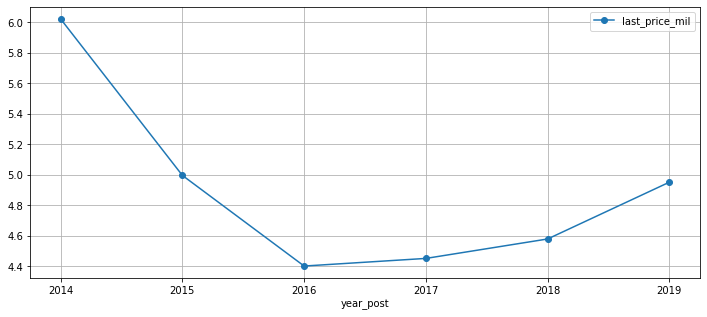

In [147]:
data_filtered.pivot_table(index='year_post', values='last_price_mil', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

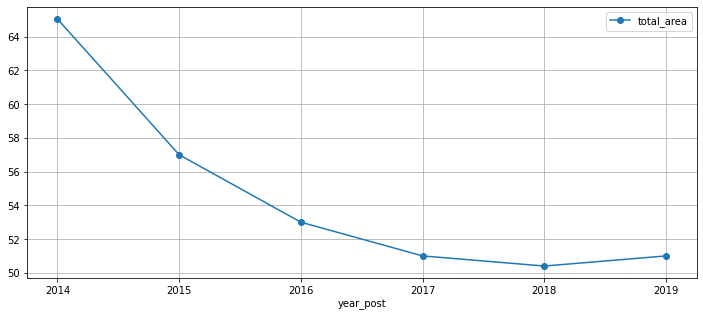

In [148]:
data_filtered.pivot_table(index='year_post', values='total_area', aggfunc='median').plot(grid=True, style ='o-', figsize=(12, 5));

<AxesSubplot:xlabel='year_post'>

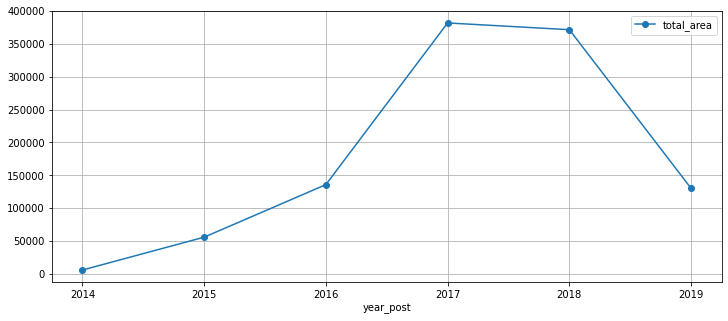

In [149]:
data_filtered.pivot_table(index='year_post', values='total_area', aggfunc='sum').plot(grid=True, style ='o-', figsize=(12, 5))

По графику, описывающему количество объявлений, можно сделать вывод, что их количество значительно выросло к 2017 году, после чего начало снижаться.

In [150]:
data_filtered['last_price_mil'].corr(data_filtered['year_post'])

-0.009882599185353419

Во всех случаях корреляция Пирсона близка к нулю. Следовательно, взаимосвязи между этими значениями не наблюдается. 

#### Промежуточный вывод

В общем можно сказать, что чем больше недвижимость, тем выше её цена. Чем больше общая площадь, жилая площадь и кухня, количество комнат, тем дороже продаётся недвижимость. 
Месяц публикации на конечную стоимость недвижимости не влияет, а вот с годами стоимость недвижимости менялась: с 2014 по 2016 снижалась, после снова начала расти. Вероятно, это связано с площадью недвижимости: уже установлено, что цена и площадь недвижимости взаимосвязаны, а площадь продаваемой недвижимости с годами изменялась практически также, как цена. Количество объявлений возрастало к 2017 году, после чего начало снижаться.

### Расчёт средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Изучим, какие населённые пункты имеют больше всего объявлений.

In [151]:
data_filtered['locality_name'].value_counts().head(10)

санкт-петербург    12600
мурино               433
шушары               374
кудрово              349
всеволожск           332
колпино              309
пушкин               303
гатчина              278
парголово            262
выборг               183
Name: locality_name, dtype: int64

Мы получили 10 населённых пунктов, в которых было опубликовано больше всего объявлений о продаже недвижимости. Рассчитаем среднюю цену квадратного метра для каждого из них. 

In [152]:
spb = data_filtered.loc[(data_filtered['locality_name'] == 'санкт-петербург')]
spb_mean = int(spb['price_for_meter'].mean())
spb_mean

107525

Средняя цена квадратного метра в Санкт-Петербурге - 107 525 рублей.  

In [153]:
murino = data_filtered.loc[(data_filtered['locality_name'] == 'мурино')]
murino_mean = int(murino['price_for_meter'].mean())
murino_mean

85250

Средняя цена квадратного метра в Мурино - 82 250 рублей.  

In [154]:
kudrovo = data_filtered.loc[(data_filtered['locality_name'] == 'кудрово')]
kudrovo_mean = int(kudrovo['price_for_meter'].mean())
kudrovo_mean

95038

Средняя цена квадратного метра в Кудрово - 95 038 рублей.  

In [155]:
shusharu = data_filtered.loc[(data_filtered['locality_name'] == 'шушары')]
shusharu_mean = int(shusharu['price_for_meter'].mean())
shusharu_mean

78081

Средняя цена квадратного метра в Шушарах - 78 081 рубля.  

In [156]:
vsevolozsk = data_filtered.loc[(data_filtered['locality_name'] == 'всеволожск')]
vsevolozsk_mean = int(vsevolozsk['price_for_meter'].mean())
vsevolozsk_mean

67174

Средняя цена квадратного метра во Всеволожске - 67 174 рублей.  

In [157]:
pushkin = data_filtered.loc[(data_filtered['locality_name'] == 'пушкин')]
pushkin_mean = int(pushkin['price_for_meter'].mean())
pushkin_mean

101085

Средняя цена квадратного метра в Пушкине - 101 085 рублей.  

In [158]:
kolpino = data_filtered.loc[(data_filtered['locality_name'] == 'колпино')]
kolpino_mean = int(kolpino['price_for_meter'].mean())
kolpino_mean

75081

Средняя цена квадратного метра в Колпино - 75 081 рубля.  

In [159]:
pargolovo = data_filtered.loc[(data_filtered['locality_name'] == 'парголово')]
pargolovo_mean = int(pargolovo['price_for_meter'].mean())
pargolovo_mean 

89838

Средняя цена квадратного метра в Парголово - 89 838 рубля.  

In [160]:
gatchina = data_filtered.loc[(data_filtered['locality_name'] == 'гатчина')]
gatchina_mean = int(gatchina['price_for_meter'].mean())
gatchina_mean 

68490

Средняя цена квадратного метра в Гатчине - 68 490 рублей. 

In [161]:
vyborg = data_filtered.loc[(data_filtered['locality_name'] == 'выборг')]
vyborg_mean = int(vyborg['price_for_meter'].mean())
vyborg_mean

58486

Средняя цена квадратного метра в Выборге - 58 486 рублей.  

Представим полученные данные в таблице, отсортированной от наименьшего значения к наибольшему:

In [162]:
tab_top_10 = pd.DataFrame({'Населённый пункт' : ['санкт-петербург', 'мурино', 'кудрово', 'шушары', 'всеволожск', 'пушкин', 'колпино', 'парголово', 'гатчина', 'выборг'], 'Цена квадратного метра' : [spb_mean, murino_mean, kudrovo_mean, shusharu_mean, vsevolozsk_mean, pushkin_mean, kolpino_mean, pargolovo_mean, gatchina_mean, vyborg_mean]})
tab_top_10.sort_values(by='Цена квадратного метра')

,Населённый пункт,Цена квадратного метра
9,выборг,58486
4,всеволожск,67174
8,гатчина,68490
6,колпино,75081
3,шушары,78081
1,мурино,85250
7,парголово,89838
2,кудрово,95038
5,пушкин,101085
0,санкт-петербург,107525


#### Промежуточный вывод

Установлено, что среди 10 городов с наибольшим количеством объявлений наибольшую стоимость за квадратный метр имеет Санкт-Петербург - 107 525 рублей, а наименьшую - Выборг, 58 486 рублей. 

In [163]:
# check
tab_top_10['Населённый пункт']

0    санкт-петербург
1             мурино
2            кудрово
3             шушары
4         всеволожск
5             пушкин
6            колпино
7          парголово
8            гатчина
9             выборг
Name: Населённый пункт, dtype: object

In [164]:
# check
tab_top_10['Цена квадратного метра']

0    107525
1     85250
2     95038
3     78081
4     67174
5    101085
6     75081
7     89838
8     68490
9     58486
Name: Цена квадратного метра, dtype: int64

<AxesSubplot:title={'center':'Цены в 10 самых популярных населённых пунктах'}, xlabel='Населённый пункт'>

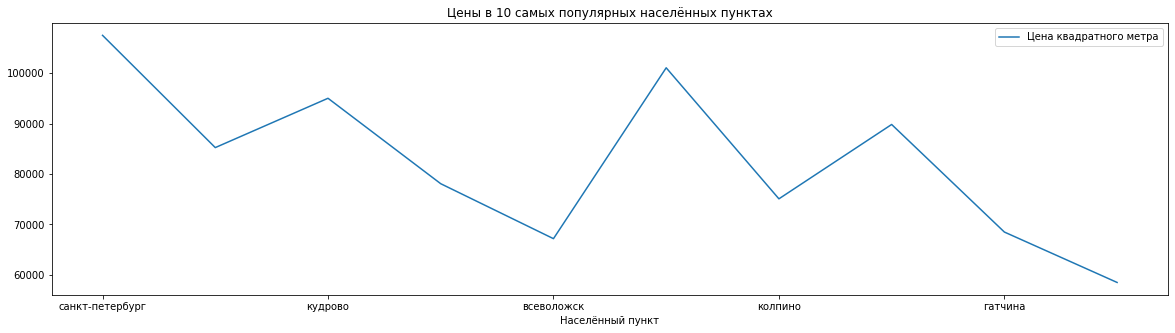

In [165]:
tab_top_10.plot(x='Населённый пункт', y='Цена квадратного метра', title='Цены в 10 самых популярных населённых пунктах', xlabel = 'Населённый пункт', figsize=(20,5))

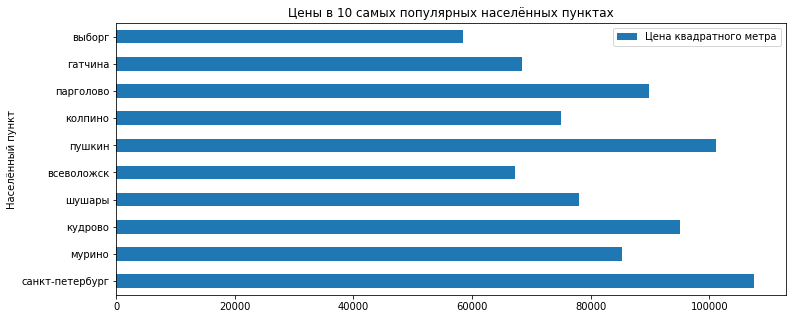

In [166]:
# check
(
    tab_top_10.plot.barh(x='Населённый пункт', y='Цена квадратного метра', \
                         title='Цены в 10 самых популярных населённых пунктах', xlabel = 'Населённый пункт', figsize=(12,5))
);

### Расчёт средней цены одного километра от центра города в Санкт-Петербурге

Необходимо рассчитать среднюю цену одного километра от центра города в Санкт-Петербурге. В предыдущем задании мы уже создали датафрейм, хранящий отдельно данные обо всех объявлениях из Санкт-Петербурга. 

In [167]:
median = spb.sort_values(by='cityCenters_nearest_km')
median = median['last_price'].median()
median

5350000.0

Построим график для наглядности:

<AxesSubplot:xlabel='cityCenters_nearest_km'>

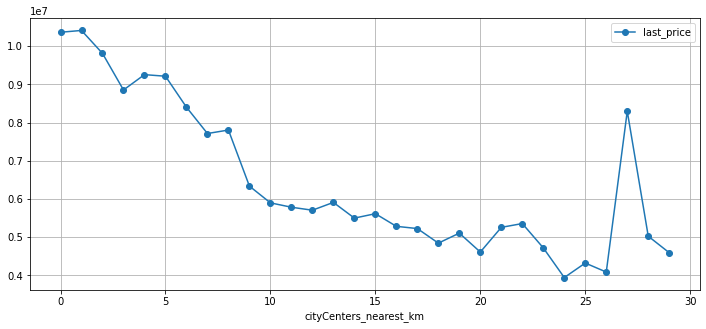

In [168]:
(
    spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
    .plot(grid=True, style ='o-', figsize=(12, 5))
)

Также наблюдается значительный провал и выброс на 26 и 27 километрах. Чтобы выяснить, с чем это связано, посмотрим распределение по средней общей площади недвижимости в зависимости от удалённости от центра города. 

<AxesSubplot:xlabel='cityCenters_nearest_km'>

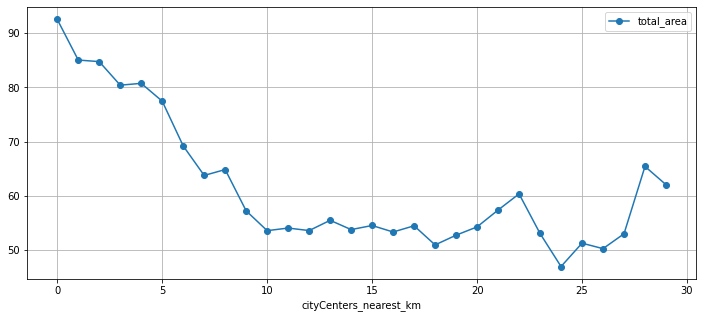

In [169]:
(
    spb.pivot_table(index='cityCenters_nearest_km', values='total_area', aggfunc='mean')
    .plot(grid=True, style ='o-', figsize=(12, 5))
)

In [170]:
spb.groupby(['cityCenters_nearest_km', 'category_floor'])['cityCenters_nearest_km'].count()

cityCenters_nearest_km  category_floor
0.0                     другой            10
                        первый             1
                        последний          2
1.0                     другой            72
                        первый            13
                                          ..
28.0                    первый             2
                        последний          1
29.0                    другой             1
                        первый             3
                        последний          1
Name: cityCenters_nearest_km, Length: 89, dtype: int64

Рассмотрим конкретно 27 километр, чтобы понять источники пиков и изменений. 

In [171]:
spb[spb['cityCenters_nearest_km'] == 27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_post,month_post,year_post,category_floor,cityCenters_nearest_km,last_price_mil
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0,NaN,128.0,193918.918919,1,11,2017,другой,27.0,14.35
5961,6,2250000,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,0,NaN,178.0,70312.500000,1,2,2018,последний,27.0,2.25


На 27 километре расположено только две квартиры, но цена одной из них - 14 350 000. С этим и связано странное поведение графика.

Наблюдается аналогичный провал, что объясняет падение цены: в этой местности недвижимость имеет значительно меньшую площадь.

На примере этого графика видно, что цена действительно сильно зависит от расстояния до центра города, и чем больше расстояние до центра, тем дороже становится недвижимость.

In [172]:
# check
spb.groupby(['cityCenters_nearest_km', 'category_floor'])['cityCenters_nearest_km'].count().head(18)

cityCenters_nearest_km  category_floor
0.0                     другой             10
                        первый              1
                        последний           2
1.0                     другой             72
                        первый             13
                        последний          32
2.0                     другой            102
                        первый             34
                        последний          51
3.0                     другой            152
                        первый             43
                        последний          64
4.0                     другой            365
                        первый             58
                        последний          78
5.0                     другой            482
                        первый             58
                        последний          86
Name: cityCenters_nearest_km, dtype: int64

#### Промежуточный вывод

Цена недвижимости действительно зависит от удалённости от центра города. Средняя цена одного километра в Санкт-Петербурге - 5 350 000. 
На графике также наблюдается значительный провал на 27 километре, объясняющийся всего двумя объявлениями в этой местности. 

### Общий вывод

В этом проекте я исследовала и анализировала датафрейм с данными о недвижимости в различных населённых пунктах. В ходе исследования был выявлен ряд важных зависимостей. 

На первом этапе в ходе предобработки были заполнены пропуски там, где было возможно предположить замену, удалены аномальные значения, искажающие точность данных, и устранены неявные дубликаты.
При сборе данных в дальнейшем для большей точности желательно уделить внимание данным о расстоянии до ближайших парков, центров города и водоёмов. Во многих столбцах здесь имеются пропуски, а предположить логичную замену нельзя.

На втором этапе были добавлены новые столбцы, важные для дальнейших расчётов: цена одного квадратного метра недвижимости, дата и день недели публикации объявления, тип этажа квартиры и расстояние до центра города в километрах. 

На третьем этапе были изучены все параметры объектов. Гистограммы подтверждают правильность проведённой предобработки, показывая нормальное рассеяние там, где это логично. 
Большая часть квартир имеет площадь до 100 квадратных метров, жилую площадь менее 50 и площадь кухни менее 20 квадратных метров. В гистограмме площади кухни наблюдается пик около 0: это обуcловлено тем, что в квартирах-студиях отсутствует выделенная кухня, поэтому её площадь указывают как 0. В большинстве квартир 1 или 2 комнаты. Большая часть квартир находится с 1 по 5 этаж, также обширна группа квартир с 5 по 9. Квартир, расположенных выше, чем на 9 этаже, немного. Чаще всего квартиры расположены не на первом или последнем этажах.
Большая часть квартир находятся в пределах 20 километров от центра города, 40 километров от аэропорта и километра от парков. Чаще всего объявления публикуют в будние дни, весной и осенью.

На четвёртом этапе была изучена скорость продажи квартиры. Среднее арифметическое и медианное значения различаются почти в два раза. Необычно быстрыми можно считать продажи за 40 и менее дней, а необычно длинными - продажи дольше 200 дней.
Также замечено, что скорость продажи значительно выросла с 2014 года.

На пятом этапе были изучены факторы, сильнее всего влияющие на стоимость объекта. В общем можно сказать, что чем больше недвижимость, тем выше её цена. Чем больше общая площадь, жилая площадь и кухня, количество комнат, тем дороже продаётся недвижимость. День недели и месяц на конечную стоимость не влияет, а от года публикации зависит: цены показали снижение к 2016 году с последующим подъёмом на прежний уровень. Количество объявлений возросло к 2017 году и затем снова начало снижаться.

На шестом этапе были изучены цены на квадратный метр недвижимости в 10 населённых пунктах, имеющих больше всего опубликованных объявлений. Установлено, что среди 10 городов с наибольшим количеством объявлений наибольшую стоимость за квадратный метр имеет Санкт-Петербург - 107 528 рублей, а наименьшую - Выборг, 58 583 рублей.

На седьмом этапе была исследована стоимость одного километра в расстоянии до центра города в Санкт-Петербурге. Она составила 5 350 000 рублей: это очень большое влияние на конечную стоимость. Также изучено странное поведение графика на 27 километре от центра города: оно было связано с тем, что в этом месте было всего 2 объявления о продаже квартир. 